## 01-TimeSeries-Forecasting-statsmodel
The notebook explores time series forecasting techniques using the statsmodels library.

#### Imports

In [1]:
import os

import requests
import numpy as np
import pandas as pd
import chardet
import plotly.express as px
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import featuretools as ft
from featuretools.primitives import Month
from sklearn.model_selection import TimeSeriesSplit

#### Variables

In [2]:
downloadURL1 = 'https://data-donnees.ec.gc.ca/data/air/monitor/monitoring-of-atmospheric-gases/ground-level-ozone/AtmosphericGases-GroundLevelOzone-CAPMoN-AllSites-2014.csv'
downloadURL2 = 'https://data-donnees.ec.gc.ca/data/air/monitor/monitoring-of-atmospheric-gases/ground-level-ozone/AtmosphericGases-GroundLevelOzone-CAPMoN-AllSites-2015.csv'

outputFileDirectory = '../datasets'
outputFileName1 = downloadURL1.split('/')[len(downloadURL1.split('/'))-1]
outputFileName2 = downloadURL2.split('/')[len(downloadURL2.split('/'))-1]

outputFilePath1 = os.path.join(outputFileDirectory,outputFileName1)
outputFilePath2 = os.path.join(outputFileDirectory,outputFileName2)

#### Pandas configurations

In [3]:
#Show all dataframe columns
pd.set_option('display.max_columns', None)

#### Common functions

In [4]:
#Download file from web URL
def downloadDataset(downloadURL, outputFilePath):
    try:
        print(f'Downloading dataset.')
        
        #Request header required to prevent the '403 - Forbidden exception'
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.11 (KHTML, like Gecko) Chrome/23.0.1271.64 Safari/537.11',
       'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
       'Accept-Charset': 'ISO-8859-1,utf-8;q=0.7,*;q=0.3',
       'Accept-Encoding': 'none',
       'Accept-Language': 'en-US,en;q=0.8',
       'Connection': 'keep-alive'}
        
        request = requests.get(downloadURL,allow_redirects=True, headers=headers)
        file_content = request.content
        
        csv_file = open(outputFilePath, 'wb')
        csv_file.write(file_content)
        csv_file.close()
        print(f'Dataset downloaded.')
    except Exception as ex:
        print(f'In error downloadDataset(downloadURL, outputFileName): {ex}')        

In [5]:
#Get character encoding
def getCharacterEncoding(filePath):
    try:
        
        with open(filePath, 'rb') as rawdata:
            result = chardet.detect(rawdata.read(100000))
        
        return result
    
    except Exception as ex:
        print(f'In error getCharacterEncoding(filePath): {ex}')    

In [6]:
#Extract substring from start until delimiter
def extractSubstringUntil(inputStr, delimiter):    
    try:    
        result = inputStr[:inputStr.find(delimiter)]
        result = result.rstrip()
        return result
    
    except Exception as ex:
        
        # print(f'In error extractHr(inputStr): {ex}')            
        return ''

#Test
# extractSubstringUntil('10:00:00',':')
# extractSubstringUntil('Canada // Canada','//')

In [7]:
#Plot the line chart for each item from 'y_column_values' list
def plotSimpleTimeSeries(df, chart_x_column, chart_y_column, split_by_column, split_by_column_values, chart_size_w_h, chart_x_label, chart_y_label):
    
    plt.figure(figsize=(chart_size_w_h[0], chart_size_w_h[1]*len(split_by_column_values)))
    
    plot_counter = 0
    
    for column_value in split_by_column_values:
        
        plot_counter += 1
        
        plt.subplot(len(split_by_column_values), 1, plot_counter)
        
        
        #Set the spacing between subplots
        plt.subplots_adjust(left=0.1,
                            bottom=0.1, 
                            right=0.9, 
                            top=0.9, 
                            wspace=0.4, 
                            hspace=0.4)
        
        sub_df = df[df[split_by_column].astype(str)==str(column_value)] #Applying the column value filter
        
        plt.plot(chart_x_column, chart_y_column, data = sub_df, linewidth=4)
        
        plt.title(column_value, fontsize=20)
        plt.xlabel(chart_x_label, fontsize=18)
        plt.ylabel(chart_y_label, fontsize=18)
    
    
    plt.show()   

In [8]:
#Series stationarity test
def adftest(df, dfColumn):
    #ADF null hypothesis: Series is not stationary
    test_result = adfuller(df[dfColumn].dropna())
    print("ADF Statistic: %f" % test_result[0])
    print("p-value: %f" % test_result[1])
    print("\n")

    if (test_result[1] < 0.05):
        print("Outcome: The series is stationary.")
    else:
        print("Outcome: The series is not stationary.")

    print(pd.Series(test_result[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used']))

#### Download datasets - Year 2014 and 2015

In [9]:
#Year 2014
downloadDataset(downloadURL1, outputFilePath1)

#Year 2015
downloadDataset(downloadURL2, outputFilePath2)

Dataset downloaded.
Dataset downloaded.


#### Read datasets

Chardet: The Universal Character Encoding Detector

##### Determine the encoding of the file 1

In [10]:
encodingResult = getCharacterEncoding(outputFilePath1)

print(f'File is encoded in {encodingResult}')

#Get the encoding from the dictionary result
encoding = encodingResult["encoding"]

File is encoded in {'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


##### Review file content (or use your own choice of editor)

We can see from the below that the file has some information at the top in addition to the data rows. This is useful as it suggests we should skip 'N' lines at top and bottom which are not data rows.

In [11]:
with open(outputFilePath1, encoding = encoding) as f:
    contents = f.readlines()
    
#Get number of lines in the file
no_of_lines = len(contents)
no_of_lines

143947

In [12]:
#View first 5 lines    
print(contents [0:5])

['*FILE NAME // NOM DU FICHIER,"AtmosphericGases-GroundLevelOzone-CAPMoN-AllSites-2014.csv"\n', '*DATE THIS FILE GENERATED // DATE DE CRÉATION DU FICHIER,2017-06-05\n', '*FILE CONTENTS DESCRIPTION // DESCRIPTION DU CONTENU DU FICHIER,"This file contains hourly average surface ozone mixing ratios in parts per billion by volume (ppbv) collected by the Canadian Air and Precipitation Monitoring Network (CAPMoN) of Environment and Climate Change Canada. Each mixing ratio value is accompanied by a data validity flag (see flag descriptions below) and the detection limit of the measurement. All measurements have been referenced and adjusted to a NIST primary ozone photometer. // Ce fichier contient les moyennes horaires des rapports de mélange de l’ozone à la surface, en partie  par milliard en volume (ppbv), mesurés par le Réseau canadien d’échantillonnage des précipitations et de l’air (RCEPA) d’Environnement et Changement climatique Canada. Chaque rapport de mélange est accompagné de son ma

In [13]:
#View last 5 lines    
print(contents [-5:])

[',"CAPMCASK1PHL",2014-12-31 ,20:00:00 ,2014-12-31 ,21:00:00 ,"CST",2015-01-01 ,2:00:00 ,2015-01-01 ,3:00:00 ,36.4 ,"V0",1.0\n', ',"CAPMCASK1PHL",2014-12-31 ,21:00:00 ,2014-12-31 ,22:00:00 ,"CST",2015-01-01 ,3:00:00 ,2015-01-01 ,4:00:00 ,37.2 ,"V0",1.0\n', ',"CAPMCASK1PHL",2014-12-31 ,22:00:00 ,2014-12-31 ,23:00:00 ,"CST",2015-01-01 ,4:00:00 ,2015-01-01 ,5:00:00 ,37.4 ,"V0",1.0\n', ',"CAPMCASK1PHL",2014-12-31 ,23:00:00 ,2015-01-01 ,0:00:00 ,"CST",2015-01-01 ,5:00:00 ,2015-01-01 ,6:00:00 ,37.2 ,"V0",1.0\n', '*TABLE DATA ENDS // FIN DES DONNÉES DU TABLEAU\n']


##### Dataframe - GroundLevelOzone

Based on analysis above and in separate editor of your choice, the lines to skip at top and bottom  are 105 and 1 respectively.

In [14]:
#Read CSV file as a dataframe - Ozone Readings
df_GroundLevelOzone_raw1 = pd.read_csv(filepath_or_buffer = outputFilePath1, 
                                      sep=",", 
                                      skiprows = 105, 
                                      skipfooter =1, 
                                      quotechar='"', 
                                      encoding = encoding, 
                                      encoding_errors = 'ignore',
                                      engine='python',
                                      header = None
                                     )

In [15]:
#Review top rows
df_GroundLevelOzone_raw1.head(2)

0             1            2         3            4         5    6   \
0 NaN  CAPMCAAB1EST  2014-01-01   1:00:00   2014-01-01   2:00:00   MST   
1 NaN  CAPMCAAB1EST  2014-01-01   2:00:00   2014-01-01   3:00:00   MST   

            7         8            9          10    11  12   13  
0  2014-01-01   8:00:00   2014-01-01    9:00:00   27.2  V0  1.0  
1  2014-01-01   9:00:00   2014-01-01   10:00:00   26.8  V0  1.0

In [16]:
#Review bottom rows
df_GroundLevelOzone_raw1.tail(2)

0             1            2          3            4          5    6   \
143839 NaN  CAPMCASK1PHL  2014-12-31   22:00:00   2014-12-31   23:00:00   CST   
143840 NaN  CAPMCASK1PHL  2014-12-31   23:00:00   2015-01-01    0:00:00   CST   

                 7         8            9         10    11  12   13  
143839  2015-01-01   4:00:00   2015-01-01   5:00:00   37.4  V0  1.0  
143840  2015-01-01   5:00:00   2015-01-01   6:00:00   37.2  V0  1.0

In [17]:
#Drop the first column which is blank
df_GroundLevelOzone_raw1.drop([0], axis=1, inplace = True)
df_GroundLevelOzone_raw1.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')

In [18]:
#View column name info given in file
print(contents [102:103])

['"*TABLE COLUMN NAME--SHORT FORM // NOM DE COLONNE--FORMAT COURT","SiteID","DateStartLocalTime","TimeStartLocalTime","DateEndLocalTime","TimeEndLocalTime","TimeZone","DateStartUTC","TimeStartUTC","DateEndUTC","TimeEndUTC","O3_ppbv","O3_ppbv_Flag","O3_ppbv_DetL"\n']


In [19]:
#Define column names (The table column names are available in line 104 in the file)
df_readings_columns = ['SiteID','DateStartLocalTime','TimeStartLocalTime','DateEndLocalTime','TimeEndLocalTime',
              'TimeZone','DateStartUTC','TimeStartUTC','DateEndUTC','TimeEndUTC',
              'O3_ppbv','O3_ppbv_Flag','O3_ppbv_DetL']
len(df_readings_columns)

13

In [20]:
#Add column names to dataframe
df_GroundLevelOzone_raw1.columns = df_readings_columns
df_GroundLevelOzone_raw1.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST        2014-01-01            1:00:00       2014-01-01    
1  CAPMCAAB1EST        2014-01-01            2:00:00       2014-01-01    

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC   DateEndUTC TimeEndUTC  \
0         2:00:00       MST  2014-01-01      8:00:00   2014-01-01    9:00:00    
1         3:00:00       MST  2014-01-01      9:00:00   2014-01-01   10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL  
0     27.2           V0           1.0  
1     26.8           V0           1.0

In [21]:
print(f'df_GroundLevelOzone_raw1.shape: {df_GroundLevelOzone_raw1.shape}')

df_GroundLevelOzone_raw1.shape: (143841, 13)


##### Dataframe - SiteMaster
Upon your analysis of the file content, you will notice that the file also contains additional information about the 19 sites such as site name, latitude, logitude, etc.

Note the skiprows and skipfooter parameters in cell below.

In [22]:
#Read CSV file as a dataframe - Site Information
df_SiteMaster_raw1 = pd.read_csv(filepath_or_buffer = outputFilePath1, 
                                      sep=",", 
                                      skiprows = 57, 
                                      skipfooter = no_of_lines - 75, 
                                      quotechar='"', 
                                      encoding = encoding, 
                                      encoding_errors = 'ignore',
                                      engine='python',
                                      header = None
                                     )

In [23]:
#Review top rows
df_SiteMaster_raw1.head(2)

0             1    2                                                  3   \
0 NaN  CAPMCAAB1EST  EST                                   Esther // Esther   
1 NaN  CAPMCAAB1WBP  WBP  Wood Buffalo National Park //  Parc national W...   

                           4   5         6          7    8   \
0  CA (CANADA) // CA (CANADA)  AB  51.66978 -110.20656  702   
1  CA (CANADA) // CA (CANADA)  AB  60.14653 -113.63770  284   

                                   9    10          11          12  \
0  WGS84 (World Geodetic System 1984)  MST  1994-07-11  9999-12-31   
1  WGS84 (World Geodetic System 1984)  MST  2014-10-02  9999-12-31   

                 13                                   14  
0  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m  
1  Rural // Rurales                                 5.6m

In [24]:
#Review bottom rows
df_SiteMaster_raw1.tail(5)

0             1    2                                               3   \
13 NaN  CAPMCAPQ1CPS  CPS                              Chapais // Chapais   
14 NaN  CAPMCAPQ1FRE  FRE                    Frelighsburg // Frelighsburg   
15 NaN  CAPMCAPQ1MIN  MIN                                Mingan // Mingan   
16 NaN  CAPMCAQC1RTR  RTR  Roundtop Ridge  //  Sommet Rond du mont Sutton   
17 NaN  CAPMCASK1PHL  PHL                Pinehouse Lake //  Lac Pinehouse   

                            4   5         6          7    8   \
13  CA (CANADA) // CA (CANADA)  PQ  49.82236  -74.97547  377   
14  CA (CANADA) // CA (CANADA)  PQ  45.05006  -72.86161  190   
15  CA (CANADA) // CA (CANADA)  PQ  50.27147  -64.22625    6   
16  CA (CANADA) // CA (CANADA)  QC  45.08853  -72.55289  842   
17  CA (CANADA) // CA (CANADA)  SK  55.51217 -106.72453  404   

                                    9    10          11          12  \
13  WGS84 (World Geodetic System 1984)  EST  1988-06-10  9999-12-31   
14  WGS84 (World Geodetic System 1984)  EST  2005-05-11  9999-12-31   
15  WGS84 (World Geodetic System 1984)  EST  2005-06-23  9999-12-31   
16  WGS84 (World Geodetic System 1984)  EST  2005-06-14  9999-12-31   
17  WGS84 (World Geodetic System 1984)  CST  2014-10-31  9999-12-31   

                  13                                   14  
13  Rural // Rurales                                 2.0m  
14  Rural // Rurales  1988-2010: 2.0m; 2011-onwards: 5.6m  
15  Rural // Rurales  1988-2010: 2.0m; 2011-onwards: 5.6m  
16  Rural // Rurales                                 5.0m  
17  Rural // Rurales                                 5.6m

In [25]:
#Drop the first column which is blank
df_SiteMaster_raw1.drop([0], axis=1, inplace = True)
df_SiteMaster_raw1.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')

In [26]:
#View column name info given in file
print(contents [55:56])

['*TABLE COLUMN NAME--SHORT FORM // NOM DE COLONNE--FORMAT COURT,"SiteID","SiteID_original","SiteName","CountryCode","ProvinceStateCode","Latitude_deg","Longitude_deg","GroundElevAMSL_m","LatLonRefDatum","Timezone","StartDateOfSite","EndDateOfSite","SiteLandUse","SamplingHeightAG"\n']


In [27]:
#Define column names (The table column names are available in line 104 in the file)
df_site_columns = ['SiteID','SiteID_original','SiteName','CountryCode','ProvinceStateCode',
                   'Latitude_deg','Longitude_deg','GroundElevAMSL_m','LatLonRefDatum','Timezone',
                   'StartDateOfSite','EndDateOfSite','SiteLandUse','SamplingHeightAG']
len(df_site_columns)

14

In [28]:
#Add column names to dataframe
df_SiteMaster_raw1.columns = df_site_columns
df_SiteMaster_raw1.head(2)

SiteID SiteID_original  \
0  CAPMCAAB1EST             EST   
1  CAPMCAAB1WBP             WBP   

                                            SiteName  \
0                                   Esther // Esther   
1  Wood Buffalo National Park //  Parc national W...   

                  CountryCode ProvinceStateCode  Latitude_deg  Longitude_deg  \
0  CA (CANADA) // CA (CANADA)                AB      51.66978     -110.20656   
1  CA (CANADA) // CA (CANADA)                AB      60.14653     -113.63770   

   GroundElevAMSL_m                      LatLonRefDatum Timezone  \
0               702  WGS84 (World Geodetic System 1984)      MST   
1               284  WGS84 (World Geodetic System 1984)      MST   

  StartDateOfSite EndDateOfSite       SiteLandUse  \
0      1994-07-11    9999-12-31  Rural // Rurales   
1      2014-10-02    9999-12-31  Rural // Rurales   

                      SamplingHeightAG  
0  1994-2010: 5.0m; 2011-onwards: 5.6m  
1                                 5.6m

In [29]:
print(f'df_SiteMaster_raw1.shape: {df_SiteMaster_raw1.shape}')

df_SiteMaster_raw1.shape: (18, 14)


##### Determine the encoding of the file 2

In [30]:
encodingResult = getCharacterEncoding(outputFilePath2)

print(f'File is encoded in {encodingResult}')

#Get the encoding from the dictionary result
encoding = encodingResult["encoding"]

File is encoded in {'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


##### Review file content (or use your own choice of editor)

We can see from the below that the file has some information at the top in addition to the data rows. This is useful as it suggests we should skip 'N' lines at top and bottom which are not data rows.

In [31]:
with open(outputFilePath2, encoding = encoding) as f:
    contents = f.readlines()
    
#Get number of lines in the file
no_of_lines = len(contents)
no_of_lines

158619

In [32]:
#View first 5 lines    
print(contents [0:5])

['*FILE NAME // NOM DU FICHIER,"AtmosphericGases-GroundLevelOzone-CAPMoN-AllSites-2015.csv"\n', '*DATE THIS FILE GENERATED // DATE DE CRÉATION DU FICHIER,2017-06-05\n', '*FILE CONTENTS DESCRIPTION // DESCRIPTION DU CONTENU DU FICHIER,"This file contains hourly average surface ozone mixing ratios in parts per billion by volume (ppbv) collected by the Canadian Air and Precipitation Monitoring Network (CAPMoN) of Environment and Climate Change Canada. Each mixing ratio value is accompanied by a data validity flag (see flag descriptions below) and the detection limit of the measurement. All measurements have been referenced and adjusted to a NIST primary ozone photometer. // Ce fichier contient les moyennes horaires des rapports de mélange de l’ozone à la surface, en partie  par milliard en volume (ppbv), mesurés par le Réseau canadien d’échantillonnage des précipitations et de l’air (RCEPA) d’Environnement et Changement climatique Canada. Chaque rapport de mélange est accompagné de son ma

In [33]:
#View last 5 lines    
print(contents [-5:])

[',"CAPMCASK1PHL",2015-12-31 ,20:00:00 ,2015-12-31 ,21:00:00 ,"CST",2016-01-01 ,2:00:00 ,2016-01-01 ,3:00:00 ,34.8 ,"V0",1.0\n', ',"CAPMCASK1PHL",2015-12-31 ,21:00:00 ,2015-12-31 ,22:00:00 ,"CST",2016-01-01 ,3:00:00 ,2016-01-01 ,4:00:00 ,34.6 ,"V0",1.0\n', ',"CAPMCASK1PHL",2015-12-31 ,22:00:00 ,2015-12-31 ,23:00:00 ,"CST",2016-01-01 ,4:00:00 ,2016-01-01 ,5:00:00 ,34.3 ,"V0",1.0\n', ',"CAPMCASK1PHL",2015-12-31 ,23:00:00 ,2016-01-01 ,0:00:00 ,"CST",2016-01-01 ,5:00:00 ,2016-01-01 ,6:00:00 ,34.1 ,"V0",1.0\n', '*TABLE DATA ENDS // FIN DES DONNÉES DU TABLEAU\n']


##### Dataframe - GroundLevelOzone

Based on analysis above and in separate editor of your choice, the lines to skip at top and bottom  are 105 and 1 respectively.

In [34]:
#Read CSV file as a dataframe - Ozone Readings
df_GroundLevelOzone_raw2 = pd.read_csv(filepath_or_buffer = outputFilePath2, 
                                      sep=",", 
                                      skiprows = 105, 
                                      skipfooter =1, 
                                      quotechar='"', 
                                      encoding = encoding, 
                                      encoding_errors = 'ignore',
                                      engine='python',
                                      header = None
                                     )

In [35]:
#Review top rows
df_GroundLevelOzone_raw2.head(2)

0             1            2         3            4         5    6   \
0 NaN  CAPMCAAB1EST  2015-01-01   0:00:00   2015-01-01   1:00:00   MST   
1 NaN  CAPMCAAB1EST  2015-01-01   1:00:00   2015-01-01   2:00:00   MST   

            7         8            9         10    11  12   13  
0  2015-01-01   7:00:00   2015-01-01   8:00:00   32.0  V0  1.0  
1  2015-01-01   8:00:00   2015-01-01   9:00:00   32.4  V0  1.0

In [36]:
#Review bottom rows
df_GroundLevelOzone_raw2.tail(2)

0             1            2          3            4          5    6   \
158511 NaN  CAPMCASK1PHL  2015-12-31   22:00:00   2015-12-31   23:00:00   CST   
158512 NaN  CAPMCASK1PHL  2015-12-31   23:00:00   2016-01-01    0:00:00   CST   

                 7         8            9         10    11  12   13  
158511  2016-01-01   4:00:00   2016-01-01   5:00:00   34.3  V0  1.0  
158512  2016-01-01   5:00:00   2016-01-01   6:00:00   34.1  V0  1.0

In [37]:
#Drop the first column which is blank
df_GroundLevelOzone_raw2.drop([0], axis=1, inplace = True)
df_GroundLevelOzone_raw2.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], dtype='int64')

In [38]:
#View column name info given in file
print(contents [103:104])

['"*TABLE COLUMN NAME--SHORT FORM // NOM DE COLONNE--FORMAT COURT","SiteID","DateStartLocalTime","TimeStartLocalTime","DateEndLocalTime","TimeEndLocalTime","TimeZone","DateStartUTC","TimeStartUTC","DateEndUTC","TimeEndUTC","O3_ppbv","O3_ppbv_Flag","O3_ppbv_DetL"\n']


In [39]:
#Define column names (The table column names are available in line 104 in the file)
df_readings_columns = ['SiteID','DateStartLocalTime','TimeStartLocalTime','DateEndLocalTime','TimeEndLocalTime',
              'TimeZone','DateStartUTC','TimeStartUTC','DateEndUTC','TimeEndUTC',
              'O3_ppbv','O3_ppbv_Flag','O3_ppbv_DetL']
len(df_readings_columns)

13

In [40]:
#Add column names to dataframe
df_GroundLevelOzone_raw2.columns = df_readings_columns
df_GroundLevelOzone_raw2.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST        2015-01-01            0:00:00       2015-01-01    
1  CAPMCAAB1EST        2015-01-01            1:00:00       2015-01-01    

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC   DateEndUTC TimeEndUTC  \
0         1:00:00       MST  2015-01-01      7:00:00   2015-01-01    8:00:00    
1         2:00:00       MST  2015-01-01      8:00:00   2015-01-01    9:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL  
0     32.0           V0           1.0  
1     32.4           V0           1.0

In [41]:
print(f'df_GroundLevelOzone_raw2.shape: {df_GroundLevelOzone_raw2.shape}')

df_GroundLevelOzone_raw2.shape: (158513, 13)


##### Dataframe - SiteMaster
Upon your analysis of the file content, you will notice that the file also contains additional information about the 19 sites such as site name, latitude, logitude, etc.

Note the skiprows and skipfooter parameters in cell below.

In [42]:
#Read CSV file as a dataframe - Site Information
df_SiteMaster_raw2 = pd.read_csv(filepath_or_buffer = outputFilePath2, 
                                      sep=",", 
                                      skiprows = 57, 
                                      skipfooter = no_of_lines - 76, 
                                      quotechar='"', 
                                      encoding = encoding, 
                                      encoding_errors = 'ignore',
                                      engine='python',
                                      header = None
                                     )

In [43]:
#Review top rows
df_SiteMaster_raw2.head(2)

0             1    2                                                  3   \
0 NaN  CAPMCAAB1EST  EST                                   Esther // Esther   
1 NaN  CAPMCAAB1WBP  WBP  Wood Buffalo National Park //  Parc national W...   

                           4   5         6          7    8   \
0  CA (CANADA) // CA (CANADA)  AB  51.66978 -110.20656  702   
1  CA (CANADA) // CA (CANADA)  AB  60.14653 -113.63770  284   

                                   9    10          11          12  \
0  WGS84 (World Geodetic System 1984)  MST  1994-07-11  9999-12-31   
1  WGS84 (World Geodetic System 1984)  MST  2014-10-02  9999-12-31   

                 13                                   14  
0  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m  
1  Rural // Rurales                                 5.6m

In [44]:
#Review bottom rows
df_SiteMaster_raw2.tail(5)

0             1    2                                               3   \
14 NaN  CAPMCAPQ1CPS  CPS                              Chapais // Chapais   
15 NaN  CAPMCAPQ1FRE  FRE                    Frelighsburg // Frelighsburg   
16 NaN  CAPMCAPQ1MIN  MIN                                Mingan // Mingan   
17 NaN  CAPMCAQC1RTR  RTR  Roundtop Ridge  //  Sommet Rond du mont Sutton   
18 NaN  CAPMCASK1PHL  PHL                Pinehouse Lake //  Lac Pinehouse   

                            4   5         6          7    8   \
14  CA (CANADA) // CA (CANADA)  PQ  49.82236  -74.97547  377   
15  CA (CANADA) // CA (CANADA)  PQ  45.05006  -72.86161  190   
16  CA (CANADA) // CA (CANADA)  PQ  50.27147  -64.22625    6   
17  CA (CANADA) // CA (CANADA)  QC  45.08853  -72.55289  842   
18  CA (CANADA) // CA (CANADA)  SK  55.51217 -106.72453  404   

                                    9    10          11          12  \
14  WGS84 (World Geodetic System 1984)  EST  1988-06-10  9999-12-31   
15  WGS84 (World Geodetic System 1984)  EST  2005-05-11  9999-12-31   
16  WGS84 (World Geodetic System 1984)  EST  2005-06-23  9999-12-31   
17  WGS84 (World Geodetic System 1984)  EST  2005-06-14  9999-12-31   
18  WGS84 (World Geodetic System 1984)  CST  2014-10-31  9999-12-31   

                  13                                   14  
14  Rural // Rurales                                 2.0m  
15  Rural // Rurales  1988-2010: 2.0m; 2011-onwards: 5.6m  
16  Rural // Rurales  1988-2010: 2.0m; 2011-onwards: 5.6m  
17  Rural // Rurales                                 5.0m  
18  Rural // Rurales                                 5.6m

In [45]:
#Drop the first column which is blank
df_SiteMaster_raw2.drop([0], axis=1, inplace = True)
df_SiteMaster_raw2.columns

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], dtype='int64')

In [46]:
#View column name info given in file
print(contents [55:56])

['*TABLE COLUMN NAME--SHORT FORM // NOM DE COLONNE--FORMAT COURT,"SiteID","SiteID_original","SiteName","CountryCode","ProvinceStateCode","Latitude_deg","Longitude_deg","GroundElevAMSL_m","LatLonRefDatum","Timezone","StartDateOfSite","EndDateOfSite","SiteLandUse","SamplingHeightAG"\n']


In [47]:
#Define column names (The table column names are available in line 104 in the file)
df_site_columns = ['SiteID','SiteID_original','SiteName','CountryCode','ProvinceStateCode',
                   'Latitude_deg','Longitude_deg','GroundElevAMSL_m','LatLonRefDatum','Timezone',
                   'StartDateOfSite','EndDateOfSite','SiteLandUse','SamplingHeightAG']
len(df_site_columns)

14

In [48]:
#Add column names to dataframe
df_SiteMaster_raw2.columns = df_site_columns
df_SiteMaster_raw2.head(2)

SiteID SiteID_original  \
0  CAPMCAAB1EST             EST   
1  CAPMCAAB1WBP             WBP   

                                            SiteName  \
0                                   Esther // Esther   
1  Wood Buffalo National Park //  Parc national W...   

                  CountryCode ProvinceStateCode  Latitude_deg  Longitude_deg  \
0  CA (CANADA) // CA (CANADA)                AB      51.66978     -110.20656   
1  CA (CANADA) // CA (CANADA)                AB      60.14653     -113.63770   

   GroundElevAMSL_m                      LatLonRefDatum Timezone  \
0               702  WGS84 (World Geodetic System 1984)      MST   
1               284  WGS84 (World Geodetic System 1984)      MST   

  StartDateOfSite EndDateOfSite       SiteLandUse  \
0      1994-07-11    9999-12-31  Rural // Rurales   
1      2014-10-02    9999-12-31  Rural // Rurales   

                      SamplingHeightAG  
0  1994-2010: 5.0m; 2011-onwards: 5.6m  
1                                 5.6m

In [49]:
print(f'df_SiteMaster_raw2.shape: {df_SiteMaster_raw2.shape}')

df_SiteMaster_raw2.shape: (19, 14)


#### Data Type Conversion
We have 2 dataframes, at a later point we shall combine them which will help us make more sense of dataset.

##### Dataframe - GroundLevelOzone

In [50]:
#Union the 2 dataframes (Year 2014 + 2015)
df_GroundLevelOzone_raw = pd.concat([df_GroundLevelOzone_raw1,df_GroundLevelOzone_raw2])

In [51]:
df_GroundLevelOzone_raw.head(2)
print(f'df_GroundLevelOzone_raw.shape: {df_GroundLevelOzone_raw.shape}')

df_GroundLevelOzone_raw.shape: (302354, 13)


In [52]:
#Combine Date and Time columns
df_GroundLevelOzone_raw['DateTimeStartLocalTime'] = pd.to_datetime(df_GroundLevelOzone_raw['DateStartLocalTime'].astype(str) + ' ' + df_GroundLevelOzone_raw['TimeStartLocalTime'].astype(str))
df_GroundLevelOzone_raw['DateTimeEndLocalTime'] = pd.to_datetime(df_GroundLevelOzone_raw['DateEndLocalTime'].astype(str) + ' ' + df_GroundLevelOzone_raw['TimeEndLocalTime'].astype(str))
df_GroundLevelOzone_raw.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST        2014-01-01            1:00:00       2014-01-01    
1  CAPMCAAB1EST        2014-01-01            2:00:00       2014-01-01    

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC   DateEndUTC TimeEndUTC  \
0         2:00:00       MST  2014-01-01      8:00:00   2014-01-01    9:00:00    
1         3:00:00       MST  2014-01-01      9:00:00   2014-01-01   10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0     27.2           V0           1.0    2014-01-01 01:00:00   
1     26.8           V0           1.0    2014-01-01 02:00:00   

  DateTimeEndLocalTime  
0  2014-01-01 02:00:00  
1  2014-01-01 03:00:00

In [53]:
#Review the data types - df_GroundLevelOzone_raw
df_GroundLevelOzone_raw.dtypes

SiteID                            object
DateStartLocalTime                object
TimeStartLocalTime                object
DateEndLocalTime                  object
TimeEndLocalTime                  object
TimeZone                          object
DateStartUTC                      object
TimeStartUTC                      object
DateEndUTC                        object
TimeEndUTC                        object
O3_ppbv                          float64
O3_ppbv_Flag                      object
O3_ppbv_DetL                     float64
DateTimeStartLocalTime    datetime64[ns]
DateTimeEndLocalTime      datetime64[ns]
dtype: object

In [54]:
#Update data types - df_GroundLevelOzone_raw

df_GroundLevelOzone_raw['DateStartLocalTime'] = pd.to_datetime(df_GroundLevelOzone_raw['DateStartLocalTime'])
df_GroundLevelOzone_raw['DateEndLocalTime'] = pd.to_datetime(df_GroundLevelOzone_raw['DateEndLocalTime'])

df_GroundLevelOzone_raw['DateStartUTC'] = pd.to_datetime(df_GroundLevelOzone_raw['DateStartUTC'])
df_GroundLevelOzone_raw['DateEndUTC'] = pd.to_datetime(df_GroundLevelOzone_raw['DateEndUTC'])

df_GroundLevelOzone_raw.dtypes

SiteID                            object
DateStartLocalTime        datetime64[ns]
TimeStartLocalTime                object
DateEndLocalTime          datetime64[ns]
TimeEndLocalTime                  object
TimeZone                          object
DateStartUTC              datetime64[ns]
TimeStartUTC                      object
DateEndUTC                datetime64[ns]
TimeEndUTC                        object
O3_ppbv                          float64
O3_ppbv_Flag                      object
O3_ppbv_DetL                     float64
DateTimeStartLocalTime    datetime64[ns]
DateTimeEndLocalTime      datetime64[ns]
dtype: object

##### Dataframe - SiteMaster

df_SiteMaster_raw2 has more records

In [55]:
print(f'df_SiteMaster_raw1.shape: {df_SiteMaster_raw1.shape}')
print(f'df_SiteMaster_raw2.shape: {df_SiteMaster_raw2.shape}')

df_SiteMaster_raw1.shape: (18, 14)
df_SiteMaster_raw2.shape: (19, 14)


In [56]:
df_SiteMaster_raw1.head(2)

SiteID SiteID_original  \
0  CAPMCAAB1EST             EST   
1  CAPMCAAB1WBP             WBP   

                                            SiteName  \
0                                   Esther // Esther   
1  Wood Buffalo National Park //  Parc national W...   

                  CountryCode ProvinceStateCode  Latitude_deg  Longitude_deg  \
0  CA (CANADA) // CA (CANADA)                AB      51.66978     -110.20656   
1  CA (CANADA) // CA (CANADA)                AB      60.14653     -113.63770   

   GroundElevAMSL_m                      LatLonRefDatum Timezone  \
0               702  WGS84 (World Geodetic System 1984)      MST   
1               284  WGS84 (World Geodetic System 1984)      MST   

  StartDateOfSite EndDateOfSite       SiteLandUse  \
0      1994-07-11    9999-12-31  Rural // Rurales   
1      2014-10-02    9999-12-31  Rural // Rurales   

                      SamplingHeightAG  
0  1994-2010: 5.0m; 2011-onwards: 5.6m  
1                                 5.6m

In [57]:
df_SiteMaster_raw2.head(2)

SiteID SiteID_original  \
0  CAPMCAAB1EST             EST   
1  CAPMCAAB1WBP             WBP   

                                            SiteName  \
0                                   Esther // Esther   
1  Wood Buffalo National Park //  Parc national W...   

                  CountryCode ProvinceStateCode  Latitude_deg  Longitude_deg  \
0  CA (CANADA) // CA (CANADA)                AB      51.66978     -110.20656   
1  CA (CANADA) // CA (CANADA)                AB      60.14653     -113.63770   

   GroundElevAMSL_m                      LatLonRefDatum Timezone  \
0               702  WGS84 (World Geodetic System 1984)      MST   
1               284  WGS84 (World Geodetic System 1984)      MST   

  StartDateOfSite EndDateOfSite       SiteLandUse  \
0      1994-07-11    9999-12-31  Rural // Rurales   
1      2014-10-02    9999-12-31  Rural // Rurales   

                      SamplingHeightAG  
0  1994-2010: 5.0m; 2011-onwards: 5.6m  
1                                 5.6m

In [58]:
#Review the data types - df_SiteMaster_raw
df_SiteMaster_raw1.dtypes

SiteID                object
SiteID_original       object
SiteName              object
CountryCode           object
ProvinceStateCode     object
Latitude_deg         float64
Longitude_deg        float64
GroundElevAMSL_m       int64
LatLonRefDatum        object
Timezone              object
StartDateOfSite       object
EndDateOfSite         object
SiteLandUse           object
SamplingHeightAG      object
dtype: object

In [59]:
#Review the data types - df_SiteMaster_raw
df_SiteMaster_raw2.dtypes

SiteID                object
SiteID_original       object
SiteName              object
CountryCode           object
ProvinceStateCode     object
Latitude_deg         float64
Longitude_deg        float64
GroundElevAMSL_m       int64
LatLonRefDatum        object
Timezone              object
StartDateOfSite       object
EndDateOfSite         object
SiteLandUse           object
SamplingHeightAG      object
dtype: object

In [60]:
#Update EndDateOfSite as pandas timestamp is approx 585 years, and would not allow dates ending year 9999. Set such record with max timestamp value that pandas supports.
df_SiteMaster_raw1.loc[df_SiteMaster_raw1['EndDateOfSite']=='9999-12-31', 'EndDateOfSite'] = str(pd.Timestamp.max.date())
df_SiteMaster_raw2.loc[df_SiteMaster_raw2['EndDateOfSite']=='9999-12-31', 'EndDateOfSite'] = str(pd.Timestamp.max.date())

In [61]:
#Update data types - df_SiteMaster_raw1

df_SiteMaster_raw1['StartDateOfSite'] = pd.to_datetime(df_SiteMaster_raw1['StartDateOfSite'])
df_SiteMaster_raw1['EndDateOfSite'] = pd.to_datetime(df_SiteMaster_raw1['EndDateOfSite'])

df_SiteMaster_raw1.dtypes

SiteID                       object
SiteID_original              object
SiteName                     object
CountryCode                  object
ProvinceStateCode            object
Latitude_deg                float64
Longitude_deg               float64
GroundElevAMSL_m              int64
LatLonRefDatum               object
Timezone                     object
StartDateOfSite      datetime64[ns]
EndDateOfSite        datetime64[ns]
SiteLandUse                  object
SamplingHeightAG             object
dtype: object

In [62]:
#Review changes to date values i.e. replacing year 9999 date.
df_SiteMaster_raw1.head(2)

SiteID SiteID_original  \
0  CAPMCAAB1EST             EST   
1  CAPMCAAB1WBP             WBP   

                                            SiteName  \
0                                   Esther // Esther   
1  Wood Buffalo National Park //  Parc national W...   

                  CountryCode ProvinceStateCode  Latitude_deg  Longitude_deg  \
0  CA (CANADA) // CA (CANADA)                AB      51.66978     -110.20656   
1  CA (CANADA) // CA (CANADA)                AB      60.14653     -113.63770   

   GroundElevAMSL_m                      LatLonRefDatum Timezone  \
0               702  WGS84 (World Geodetic System 1984)      MST   
1               284  WGS84 (World Geodetic System 1984)      MST   

  StartDateOfSite EndDateOfSite       SiteLandUse  \
0      1994-07-11    2262-04-11  Rural // Rurales   
1      2014-10-02    2262-04-11  Rural // Rurales   

                      SamplingHeightAG  
0  1994-2010: 5.0m; 2011-onwards: 5.6m  
1                                 5.6m

In [63]:
#Update data types - df_SiteMaster_raw2

df_SiteMaster_raw2['StartDateOfSite'] = pd.to_datetime(df_SiteMaster_raw2['StartDateOfSite'])
df_SiteMaster_raw2['EndDateOfSite'] = pd.to_datetime(df_SiteMaster_raw2['EndDateOfSite'])

df_SiteMaster_raw2.dtypes

SiteID                       object
SiteID_original              object
SiteName                     object
CountryCode                  object
ProvinceStateCode            object
Latitude_deg                float64
Longitude_deg               float64
GroundElevAMSL_m              int64
LatLonRefDatum               object
Timezone                     object
StartDateOfSite      datetime64[ns]
EndDateOfSite        datetime64[ns]
SiteLandUse                  object
SamplingHeightAG             object
dtype: object

In [64]:
#Review changes to date values i.e. replacing year 9999 date.
df_SiteMaster_raw2.head(2)

SiteID SiteID_original  \
0  CAPMCAAB1EST             EST   
1  CAPMCAAB1WBP             WBP   

                                            SiteName  \
0                                   Esther // Esther   
1  Wood Buffalo National Park //  Parc national W...   

                  CountryCode ProvinceStateCode  Latitude_deg  Longitude_deg  \
0  CA (CANADA) // CA (CANADA)                AB      51.66978     -110.20656   
1  CA (CANADA) // CA (CANADA)                AB      60.14653     -113.63770   

   GroundElevAMSL_m                      LatLonRefDatum Timezone  \
0               702  WGS84 (World Geodetic System 1984)      MST   
1               284  WGS84 (World Geodetic System 1984)      MST   

  StartDateOfSite EndDateOfSite       SiteLandUse  \
0      1994-07-11    2262-04-11  Rural // Rurales   
1      2014-10-02    2262-04-11  Rural // Rurales   

                      SamplingHeightAG  
0  1994-2010: 5.0m; 2011-onwards: 5.6m  
1                                 5.6m

#### Data Preprcessing
Now that we have the datasets in readable formats we can proceed with preprocessing step 1.

Extract the Hour column value

In [65]:
df_GroundLevelOzone_raw.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST         2014-01-01           1:00:00        2014-01-01   
1  CAPMCAAB1EST         2014-01-01           2:00:00        2014-01-01   

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
0         2:00:00       MST   2014-01-01     8:00:00  2014-01-01   9:00:00    
1         3:00:00       MST   2014-01-01     9:00:00  2014-01-01  10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0     27.2           V0           1.0    2014-01-01 01:00:00   
1     26.8           V0           1.0    2014-01-01 02:00:00   

  DateTimeEndLocalTime  
0  2014-01-01 02:00:00  
1  2014-01-01 03:00:00

In [66]:
#What are the unique values in this column?
df_GroundLevelOzone_raw['TimeStartLocalTime'].unique()

array(['1:00:00 ', '2:00:00 ', '3:00:00 ', '4:00:00 ', '5:00:00 ',
       '6:00:00 ', '7:00:00 ', '8:00:00 ', '9:00:00 ', '10:00:00 ',
       '11:00:00 ', '12:00:00 ', '13:00:00 ', '14:00:00 ', '15:00:00 ',
       '16:00:00 ', '17:00:00 ', '18:00:00 ', '19:00:00 ', '20:00:00 ',
       '21:00:00 ', '22:00:00 ', '23:00:00 ', '0:00:00 '], dtype=object)

In [67]:
df_GroundLevelOzone_raw['HrStartLocalTime'] = df_GroundLevelOzone_raw['TimeStartLocalTime'].apply(extractSubstringUntil, args=(':'))
df_GroundLevelOzone_raw['HrEndLocalTime'] = df_GroundLevelOzone_raw['TimeEndLocalTime'].apply(extractSubstringUntil, args=(':'))
df_GroundLevelOzone_raw['HrStartUTC'] = df_GroundLevelOzone_raw['TimeStartUTC'].apply(extractSubstringUntil, args=(':'))
df_GroundLevelOzone_raw['HrEndUTC'] = df_GroundLevelOzone_raw['TimeEndUTC'].apply(extractSubstringUntil, args=(':'))

In [68]:
df_GroundLevelOzone_raw.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST         2014-01-01           1:00:00        2014-01-01   
1  CAPMCAAB1EST         2014-01-01           2:00:00        2014-01-01   

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
0         2:00:00       MST   2014-01-01     8:00:00  2014-01-01   9:00:00    
1         3:00:00       MST   2014-01-01     9:00:00  2014-01-01  10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0     27.2           V0           1.0    2014-01-01 01:00:00   
1     26.8           V0           1.0    2014-01-01 02:00:00   

  DateTimeEndLocalTime HrStartLocalTime HrEndLocalTime HrStartUTC HrEndUTC  
0  2014-01-01 02:00:00                1              2          8        9  
1  2014-01-01 03:00:00                2              3          9       10

Update data types

In [69]:
df_GroundLevelOzone_raw['HrStartLocalTime'] = df_GroundLevelOzone_raw['HrStartLocalTime'].astype('int')
df_GroundLevelOzone_raw['HrEndLocalTime'] = df_GroundLevelOzone_raw['HrEndLocalTime'].astype('int')
df_GroundLevelOzone_raw['HrStartUTC'] = df_GroundLevelOzone_raw['HrStartUTC'].astype('int')
df_GroundLevelOzone_raw['HrEndUTC'] = df_GroundLevelOzone_raw['HrEndUTC'].astype('int')

Merge the Site information into the Ozone Readings.

In [70]:
df_GroundLevelOzone_merged = pd.merge(df_GroundLevelOzone_raw,df_SiteMaster_raw2, on = 'SiteID', how = 'left').copy(deep = True)

#To validate if row counts have not changed after the merge.
print(f'df_GroundLevelOzone_raw.shape: {df_GroundLevelOzone_raw.shape} \ndf_SiteMaster_raw2.shape: {df_SiteMaster_raw2.shape} \ndf_GroundLevelOzone_merged.shape: {df_GroundLevelOzone_merged.shape}\n')

df_GroundLevelOzone_merged.head(2)

df_GroundLevelOzone_raw.shape: (302354, 19) 
df_SiteMaster_raw2.shape: (19, 14) 
df_GroundLevelOzone_merged.shape: (302354, 32)



SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST         2014-01-01           1:00:00        2014-01-01   
1  CAPMCAAB1EST         2014-01-01           2:00:00        2014-01-01   

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
0         2:00:00       MST   2014-01-01     8:00:00  2014-01-01   9:00:00    
1         3:00:00       MST   2014-01-01     9:00:00  2014-01-01  10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0     27.2           V0           1.0    2014-01-01 01:00:00   
1     26.8           V0           1.0    2014-01-01 02:00:00   

  DateTimeEndLocalTime  HrStartLocalTime  HrEndLocalTime  HrStartUTC  \
0  2014-01-01 02:00:00                 1               2           8   
1  2014-01-01 03:00:00                 2               3           9   

   HrEndUTC SiteID_original          SiteName                 CountryCode  \
0         9             EST  Esther // Esther  CA (CANADA) // CA (CANADA)   
1        10             EST  Esther // Esther  CA (CANADA) // CA (CANADA)   

  ProvinceStateCode  Latitude_deg  Longitude_deg  GroundElevAMSL_m  \
0                AB      51.66978     -110.20656               702   
1                AB      51.66978     -110.20656               702   

                       LatLonRefDatum Timezone StartDateOfSite EndDateOfSite  \
0  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   
1  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   

        SiteLandUse                     SamplingHeightAG  
0  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m  
1  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m

Extract and update Site Name

In [71]:
df_GroundLevelOzone_merged['SiteName'] = df_GroundLevelOzone_merged['SiteName'].apply(extractSubstringUntil,args=('/'))
df_GroundLevelOzone_merged.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST         2014-01-01           1:00:00        2014-01-01   
1  CAPMCAAB1EST         2014-01-01           2:00:00        2014-01-01   

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
0         2:00:00       MST   2014-01-01     8:00:00  2014-01-01   9:00:00    
1         3:00:00       MST   2014-01-01     9:00:00  2014-01-01  10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0     27.2           V0           1.0    2014-01-01 01:00:00   
1     26.8           V0           1.0    2014-01-01 02:00:00   

  DateTimeEndLocalTime  HrStartLocalTime  HrEndLocalTime  HrStartUTC  \
0  2014-01-01 02:00:00                 1               2           8   
1  2014-01-01 03:00:00                 2               3           9   

   HrEndUTC SiteID_original SiteName                 CountryCode  \
0         9             EST   Esther  CA (CANADA) // CA (CANADA)   
1        10             EST   Esther  CA (CANADA) // CA (CANADA)   

  ProvinceStateCode  Latitude_deg  Longitude_deg  GroundElevAMSL_m  \
0                AB      51.66978     -110.20656               702   
1                AB      51.66978     -110.20656               702   

                       LatLonRefDatum Timezone StartDateOfSite EndDateOfSite  \
0  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   
1  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   

        SiteLandUse                     SamplingHeightAG  
0  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m  
1  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m

Review summary statistics.

It appears that there are missing values for Ozone (ppbv: parts per billion by volume). 

The information in the dataset top section suggests that - Values of -999.0 represent missing or invalid data. 

In [72]:
df_GroundLevelOzone_merged.describe()

O3_ppbv   O3_ppbv_DetL  HrStartLocalTime  HrEndLocalTime  \
count  302354.000000  302354.000000     302354.000000   302354.000000   
mean      -70.398468       1.041974         11.500281       11.500129   
std       304.832234       0.200530          6.922333        6.922363   
min      -999.000000       1.000000          0.000000        0.000000   
25%        19.400000       1.000000          6.000000        5.250000   
50%        28.600000       1.000000         12.000000       11.500000   
75%        35.600000       1.000000         18.000000       18.000000   
max       100.100000       2.000000         23.000000       23.000000   

          HrStartUTC       HrEndUTC   Latitude_deg  Longitude_deg  \
count  302354.000000  302354.000000  302354.000000  302354.000000   
mean       11.499630      11.499636      51.721209     -84.945333   
std         6.922251       6.922198       9.136308      19.303065   
min         0.000000       0.000000      44.231000    -123.127530   
25%         5.000000       5.000000      45.088530     -93.732770   
50%        11.000000      11.000000      49.664080     -79.791720   
75%        17.000000      17.000000      51.669780     -72.552890   
max        23.000000      23.000000      82.450830     -60.363140   

       GroundElevAMSL_m  
count     302354.000000  
mean         303.807540  
std          208.717521  
min            6.000000  
25%          187.000000  
50%          242.000000  
75%          404.000000  
max          842.000000

In [73]:
#View extent of missing values for the column O3_ppbv
perc_missing_O3_ppbv = (df_GroundLevelOzone_merged.loc[df_GroundLevelOzone_merged['O3_ppbv']==-999].shape[0] /df_GroundLevelOzone_merged.shape[0])*100
print(f'perc_missing_O3_ppbv in dataset: {perc_missing_O3_ppbv} %')

perc_missing_O3_ppbv in dataset: 9.718740284567097 %


In [74]:
#Replace missing values with na
# df_GroundLevelOzone_merged.loc[df_GroundLevelOzone_merged['O3_ppbv']==-999, 'O3_ppbv'] = np.NaN
# df_GroundLevelOzone_merged.loc[df_GroundLevelOzone_merged['O3_ppbv'].isnull()].shape

#Handle missing values by replacing them with mean
imp_mean = SimpleImputer(missing_values=-999, strategy='mean')
imp_mean.fit(df_GroundLevelOzone_merged['O3_ppbv'].to_numpy().reshape(-1,1))
O3_ppbv_imputed = imp_mean.transform(df_GroundLevelOzone_merged['O3_ppbv'].to_numpy().reshape(-1,1))

# df_GroundLevelOzone_merged.shape
# len(O3_ppbv_imputed[0])

df_GroundLevelOzone_merged['O3_ppbv_imputed'] = O3_ppbv_imputed

In [75]:
#Validate if existing values are unchanged
df_GroundLevelOzone_merged.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST         2014-01-01           1:00:00        2014-01-01   
1  CAPMCAAB1EST         2014-01-01           2:00:00        2014-01-01   

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
0         2:00:00       MST   2014-01-01     8:00:00  2014-01-01   9:00:00    
1         3:00:00       MST   2014-01-01     9:00:00  2014-01-01  10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0     27.2           V0           1.0    2014-01-01 01:00:00   
1     26.8           V0           1.0    2014-01-01 02:00:00   

  DateTimeEndLocalTime  HrStartLocalTime  HrEndLocalTime  HrStartUTC  \
0  2014-01-01 02:00:00                 1               2           8   
1  2014-01-01 03:00:00                 2               3           9   

   HrEndUTC SiteID_original SiteName                 CountryCode  \
0         9             EST   Esther  CA (CANADA) // CA (CANADA)   
1        10             EST   Esther  CA (CANADA) // CA (CANADA)   

  ProvinceStateCode  Latitude_deg  Longitude_deg  GroundElevAMSL_m  \
0                AB      51.66978     -110.20656               702   
1                AB      51.66978     -110.20656               702   

                       LatLonRefDatum Timezone StartDateOfSite EndDateOfSite  \
0  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   
1  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   

        SiteLandUse                     SamplingHeightAG  O3_ppbv_imputed  
0  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m             27.2  
1  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m             26.8

In [76]:
#Validate results if values getting replaced correctly
df_GroundLevelOzone_merged.loc[df_GroundLevelOzone_merged['O3_ppbv']==-999].head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
9    CAPMCAAB1EST         2014-01-01          10:00:00        2014-01-01   
153  CAPMCAAB1EST         2014-01-07          10:00:00        2014-01-07   

    TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
9          11:00:00       MST   2014-01-01    17:00:00  2014-01-01  18:00:00    
153        11:00:00       MST   2014-01-07    17:00:00  2014-01-07  18:00:00    

     O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
9     -999.0           M1           1.0    2014-01-01 10:00:00   
153   -999.0           M1           1.0    2014-01-07 10:00:00   

    DateTimeEndLocalTime  HrStartLocalTime  HrEndLocalTime  HrStartUTC  \
9    2014-01-01 11:00:00                10              11          17   
153  2014-01-07 11:00:00                10              11          17   

     HrEndUTC SiteID_original SiteName                 CountryCode  \
9          18             EST   Esther  CA (CANADA) // CA (CANADA)   
153        18             EST   Esther  CA (CANADA) // CA (CANADA)   

    ProvinceStateCode  Latitude_deg  Longitude_deg  GroundElevAMSL_m  \
9                  AB      51.66978     -110.20656               702   
153                AB      51.66978     -110.20656               702   

                         LatLonRefDatum Timezone StartDateOfSite  \
9    WGS84 (World Geodetic System 1984)      MST      1994-07-11   
153  WGS84 (World Geodetic System 1984)      MST      1994-07-11   

    EndDateOfSite       SiteLandUse                     SamplingHeightAG  \
9      2262-04-11  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m   
153    2262-04-11  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m   

     O3_ppbv_imputed  
9          29.565103  
153        29.565103

In [77]:
#Drop 'O3_ppbv_imputed' column and overwrite the 'O3_ppbv' with impuated values 
df_GroundLevelOzone_merged.drop(['O3_ppbv_imputed'], axis = 1)
df_GroundLevelOzone_merged['O3_ppbv'] = O3_ppbv_imputed
df_GroundLevelOzone_merged.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCAAB1EST         2014-01-01           1:00:00        2014-01-01   
1  CAPMCAAB1EST         2014-01-01           2:00:00        2014-01-01   

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
0         2:00:00       MST   2014-01-01     8:00:00  2014-01-01   9:00:00    
1         3:00:00       MST   2014-01-01     9:00:00  2014-01-01  10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0     27.2           V0           1.0    2014-01-01 01:00:00   
1     26.8           V0           1.0    2014-01-01 02:00:00   

  DateTimeEndLocalTime  HrStartLocalTime  HrEndLocalTime  HrStartUTC  \
0  2014-01-01 02:00:00                 1               2           8   
1  2014-01-01 03:00:00                 2               3           9   

   HrEndUTC SiteID_original SiteName                 CountryCode  \
0         9             EST   Esther  CA (CANADA) // CA (CANADA)   
1        10             EST   Esther  CA (CANADA) // CA (CANADA)   

  ProvinceStateCode  Latitude_deg  Longitude_deg  GroundElevAMSL_m  \
0                AB      51.66978     -110.20656               702   
1                AB      51.66978     -110.20656               702   

                       LatLonRefDatum Timezone StartDateOfSite EndDateOfSite  \
0  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   
1  WGS84 (World Geodetic System 1984)      MST      1994-07-11    2262-04-11   

        SiteLandUse                     SamplingHeightAG  O3_ppbv_imputed  
0  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m             27.2  
1  Rural // Rurales  1994-2010: 5.0m; 2011-onwards: 5.6m             26.8

In [78]:
#Sort the rows
df_GroundLevelOzone_merged.sort_values(by=['SiteID','DateStartLocalTime','HrStartLocalTime'], inplace = True)

#Reset the index
df_GroundLevelOzone_merged.reset_index(inplace = True)

#### Visualise the data

In [79]:
#Max ozone level to plot on a map
df_GroundLevelOzone_merged_grouped_mean = df_GroundLevelOzone_merged.groupby(['SiteID','SiteName','Latitude_deg','Longitude_deg','CountryCode'])['O3_ppbv'].mean()
df_GroundLevelOzone_merged_grouped_mean = pd.DataFrame(df_GroundLevelOzone_merged_grouped_mean).reset_index()
df_GroundLevelOzone_merged_grouped_mean.head()

SiteID                      SiteName  Latitude_deg  Longitude_deg  \
0  CAPMCAAB1EST                        Esther      51.66978     -110.20656   
1  CAPMCAAB1WBP    Wood Buffalo National Park      60.14653     -113.63770   
2  CAPMCABC1SAT                       Saturna      48.77503     -123.12753   
3  CAPMCANL1GOS                     Goose Bay      53.30600      -60.36314   
4  CAPMCANS1KEB  Kejimkujik National Park - B      44.40298      -65.20274   

                  CountryCode    O3_ppbv  
0  CA (CANADA) // CA (CANADA)  30.917246  
1  CA (CANADA) // CA (CANADA)  28.596790  
2  CA (CANADA) // CA (CANADA)  27.329564  
3  CA (CANADA) // CA (CANADA)  29.141110  
4  CA (CANADA) // CA (CANADA)  22.650667

##### Plot on map
Let's view the Ozone levels on the map as dataset contains the latitude and longitude details of each reading.

We can see that the reading sites are spread across the canada and the readings are slightly higher for couple of sites.

In [80]:
# help(px.density_mapbox)

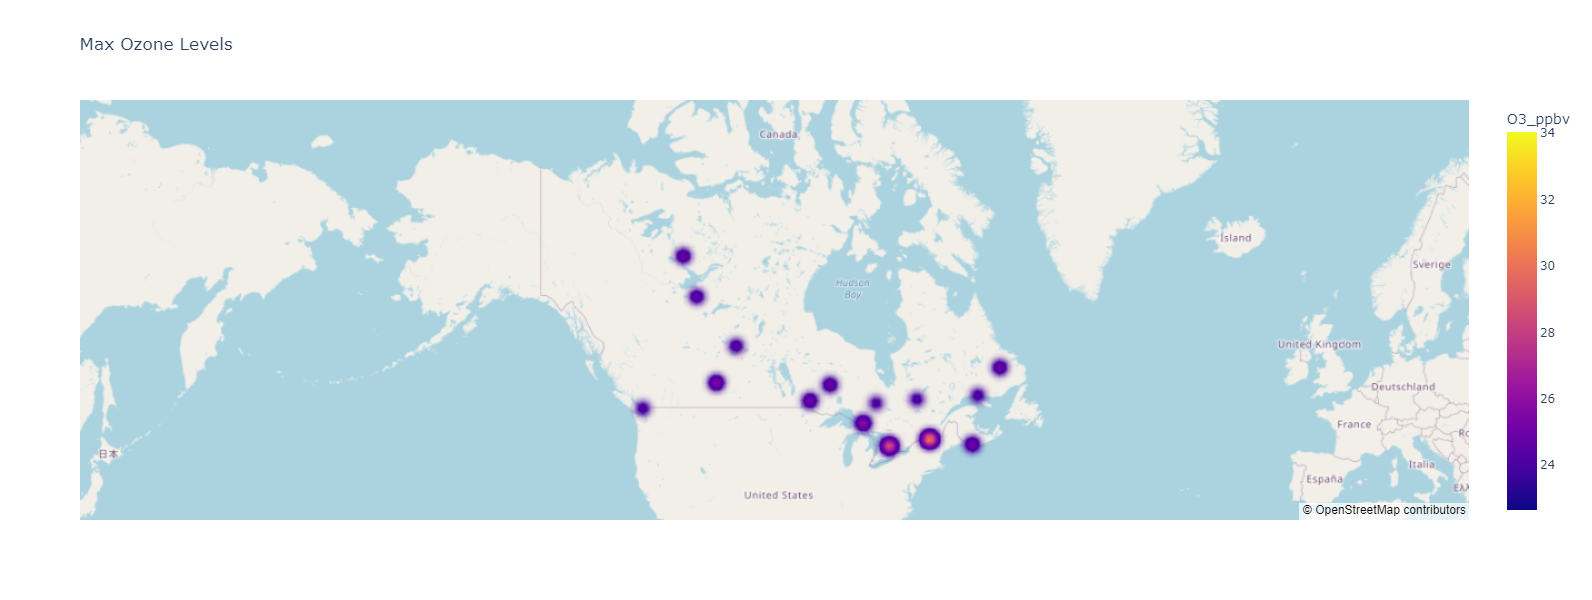

In [81]:
map_visual = px.density_mapbox(df_GroundLevelOzone_merged_grouped_mean, lat = 'Latitude_deg', lon = 'Longitude_deg', z = 'O3_ppbv', hover_name = 'SiteName',
                               radius = 15, zoom = 2, mapbox_style = 'open-street-map', title = 'Max Ozone Levels', width = 800, height = 600, center = dict(lat = 59, lon = -100))
map_visual.show()

In [82]:
#Since the data is collected per site, it would make sense to view each site's time series separately.
split_by_column_values = df_GroundLevelOzone_merged['SiteID'].unique()
split_by_column_values

array(['CAPMCAAB1EST', 'CAPMCAAB1WBP', 'CAPMCABC1SAT', 'CAPMCANL1GOS',
       'CAPMCANS1KEB', 'CAPMCANS1KEJ', 'CAPMCANT1SNA', 'CAPMCANU1ALT',
       'CAPMCAON1ALG', 'CAPMCAON1BON', 'CAPMCAON1EGB', 'CAPMCAON1EGP',
       'CAPMCAON1ELA', 'CAPMCAON1PKL', 'CAPMCAPQ1CPS', 'CAPMCAPQ1FRE',
       'CAPMCAPQ1MIN', 'CAPMCAQC1RTR', 'CAPMCASK1PHL'], dtype=object)

Plotting 19 charts.


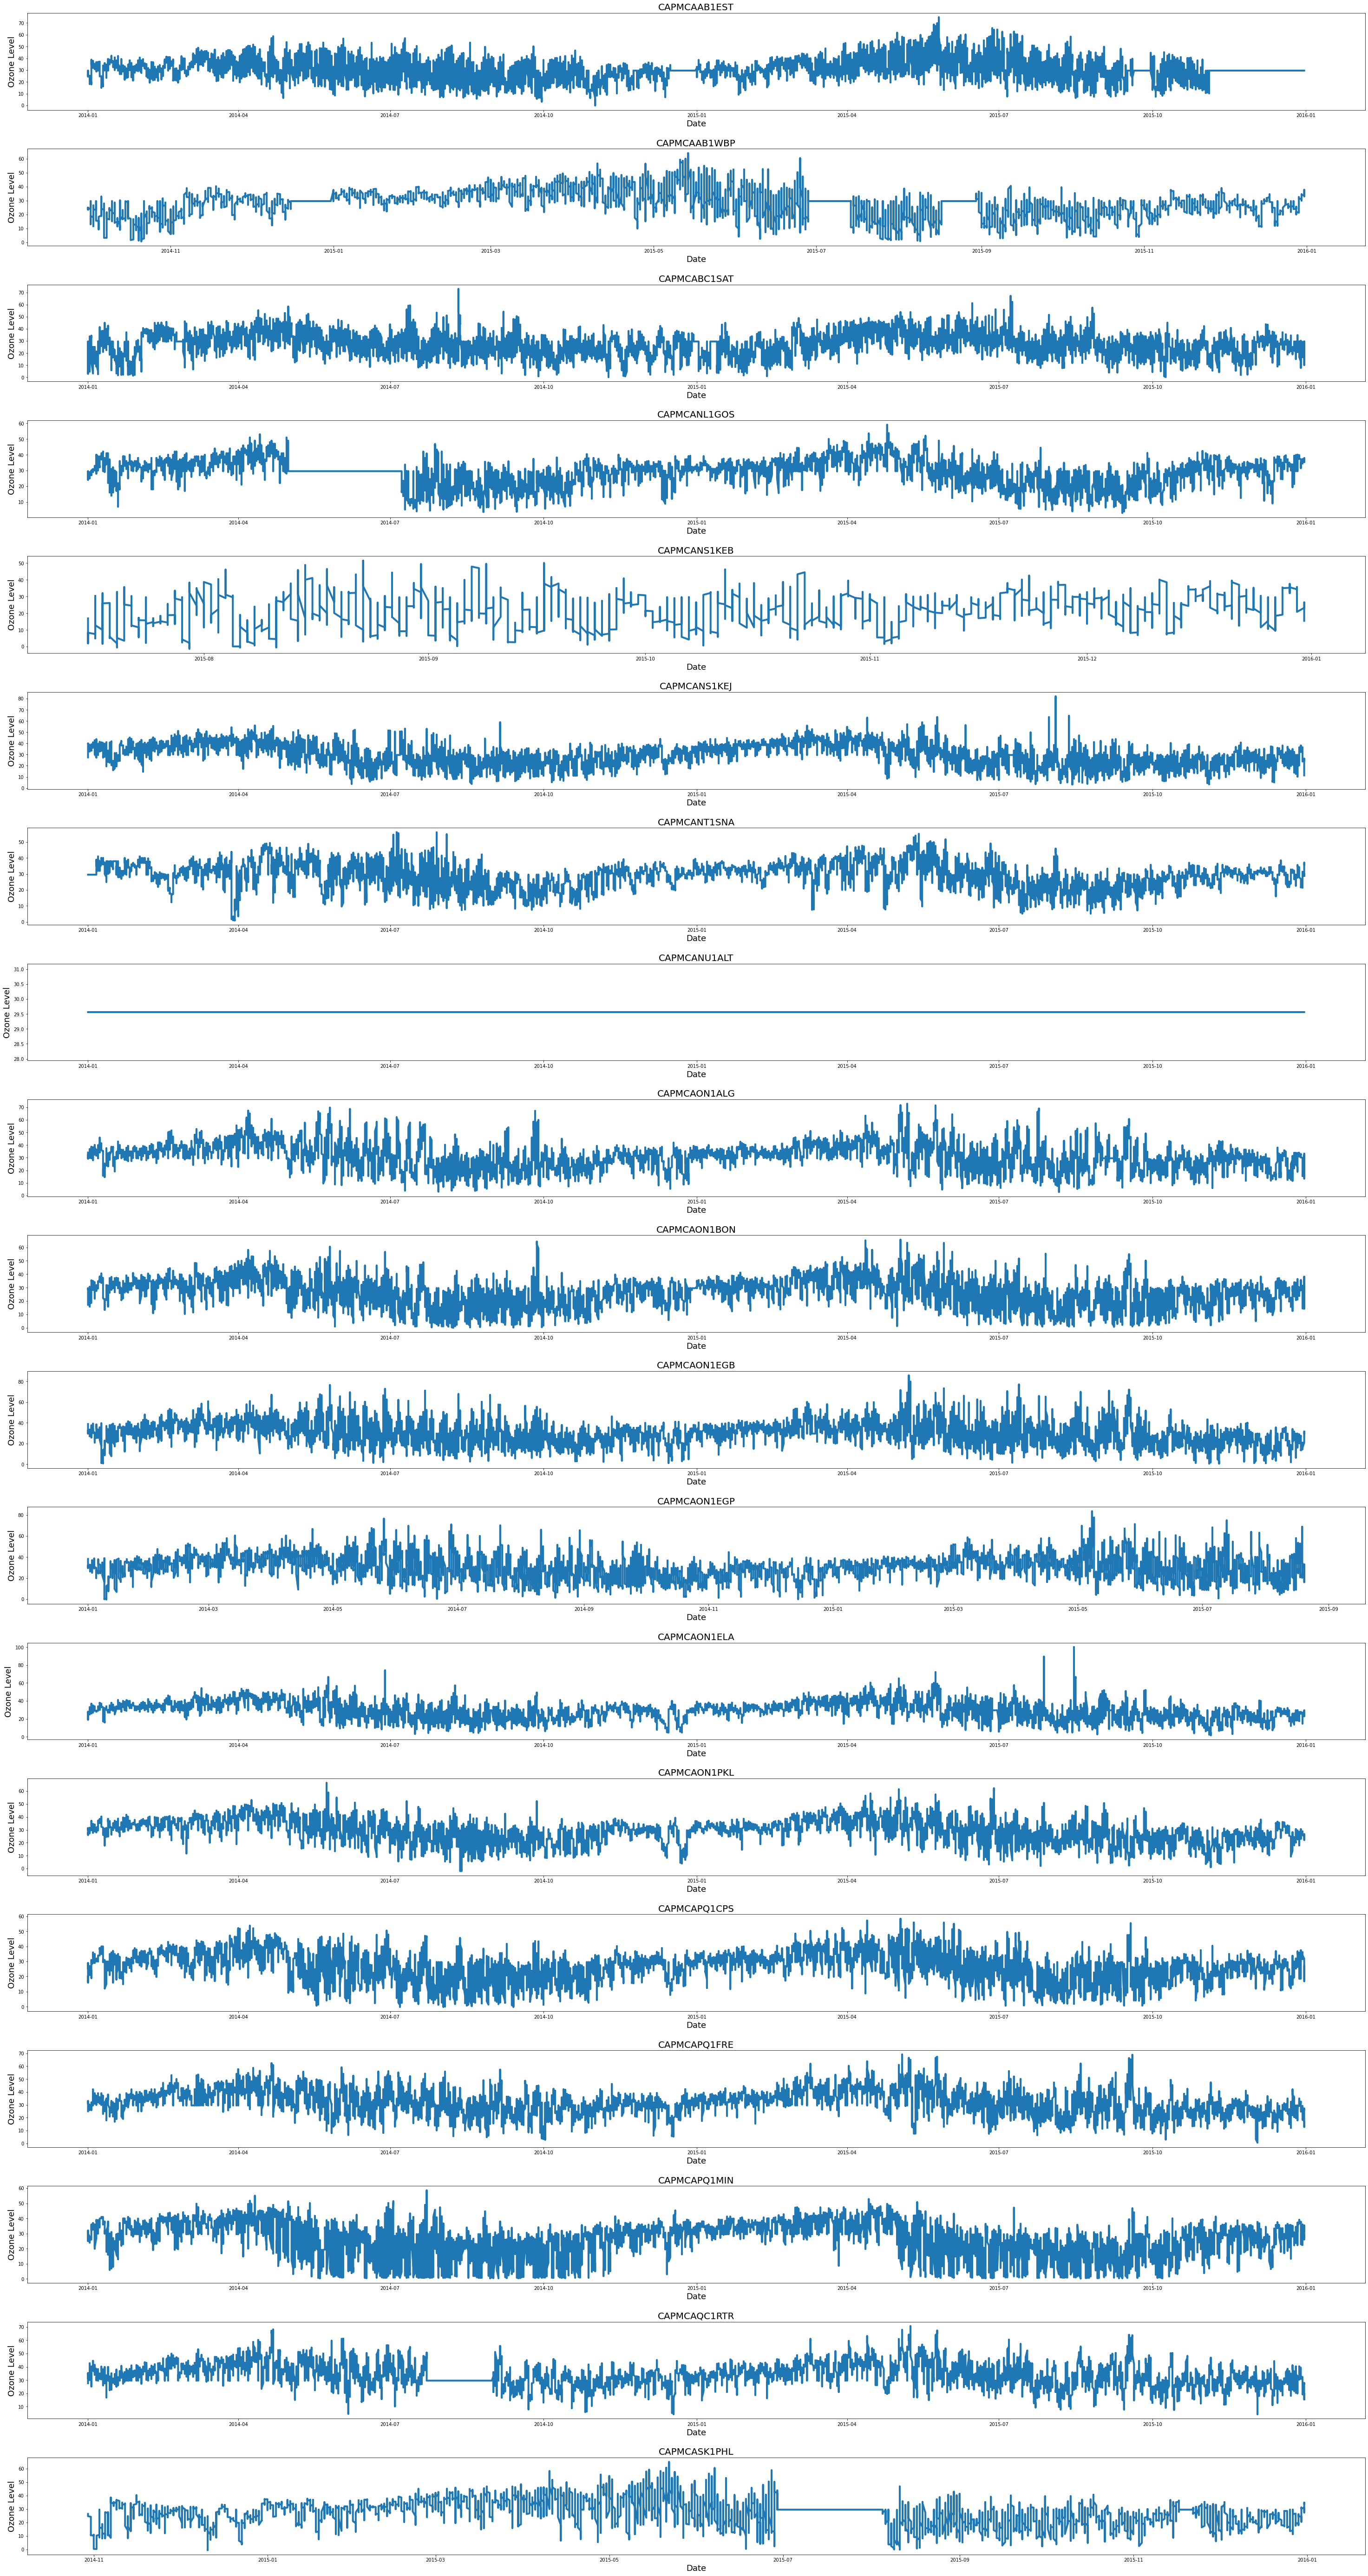

In [83]:
print(f'Plotting {len(split_by_column_values)} charts.')

#Plot Ozone Levels for each site
plotSimpleTimeSeries(df = df_GroundLevelOzone_merged, 
                     chart_x_column = 'DateStartLocalTime', 
                     chart_y_column = 'O3_ppbv', 
                     split_by_column = 'SiteID', 
                     split_by_column_values = split_by_column_values, 
                     chart_size_w_h = (50,5),
                     chart_x_label = 'Date', 
                     chart_y_label = 'Ozone Level'
                    )

##### Observations:
- We can see that sites 'CAPMCASK1PHL','CAPMCAAB1EST','CAPMCAAB1WBP' have large continuous gaps as a result of missing data.
- Site 'CAPMCANU1ALT' does not have any data of it's own.

Let's choose site 'CAPMCABC1SAT' for further exploration and modeling. Same steps and technique could be used for other sites that have continuous data available.
This also indicates that it is important to first understand if the dataset/which part of dataset is suitable to use for forecasting.

#### Site - CAPMCABC1SAT

In [84]:
#Filter the data
df_GroundLevelOzone_merged_CAPMCABC1SAT = df_GroundLevelOzone_merged.loc[df_GroundLevelOzone_merged['SiteID']=='CAPMCABC1SAT'].copy(deep=True)

#Reset index
df_GroundLevelOzone_merged_CAPMCABC1SAT.reset_index(inplace = True)

#Remove the extra columns
df_GroundLevelOzone_merged_CAPMCABC1SAT.drop(['level_0','index'], axis=1, inplace = True)

df_GroundLevelOzone_merged_CAPMCABC1SAT.head(2)

SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0  CAPMCABC1SAT         2014-01-01           0:00:00        2014-01-01   
1  CAPMCABC1SAT         2014-01-01           1:00:00        2014-01-01   

  TimeEndLocalTime TimeZone DateStartUTC TimeStartUTC DateEndUTC TimeEndUTC  \
0         1:00:00       PST   2014-01-01     8:00:00  2014-01-01   9:00:00    
1         2:00:00       PST   2014-01-01     9:00:00  2014-01-01  10:00:00    

   O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL DateTimeStartLocalTime  \
0      4.1           V0           1.0    2014-01-01 00:00:00   
1      2.9           V0           1.0    2014-01-01 01:00:00   

  DateTimeEndLocalTime  HrStartLocalTime  HrEndLocalTime  HrStartUTC  \
0  2014-01-01 01:00:00                 0               1           8   
1  2014-01-01 02:00:00                 1               2           9   

   HrEndUTC SiteID_original SiteName                 CountryCode  \
0         9             SAT  Saturna  CA (CANADA) // CA (CANADA)   
1        10             SAT  Saturna  CA (CANADA) // CA (CANADA)   

  ProvinceStateCode  Latitude_deg  Longitude_deg  GroundElevAMSL_m  \
0                BC      48.77503     -123.12753               184   
1                BC      48.77503     -123.12753               184   

                       LatLonRefDatum Timezone StartDateOfSite EndDateOfSite  \
0  WGS84 (World Geodetic System 1984)      PST      1991-05-28    2262-04-11   
1  WGS84 (World Geodetic System 1984)      PST      1991-05-28    2262-04-11   

        SiteLandUse                                   SamplingHeightAG  \
0  Rural // Rurales  1991-2000: 2.0m; 2001-2013: 3m; 2014-onwards: ...   
1  Rural // Rurales  1991-2000: 2.0m; 2001-2013: 3m; 2014-onwards: ...   

   O3_ppbv_imputed  
0              4.1  
1              2.9

In [85]:
print(f'df_GroundLevelOzone_merged_CAPMCABC1SAT.shape: {df_GroundLevelOzone_merged_CAPMCABC1SAT}')

df_GroundLevelOzone_merged_CAPMCABC1SAT.shape:              SiteID DateStartLocalTime TimeStartLocalTime DateEndLocalTime  \
0      CAPMCABC1SAT         2014-01-01           0:00:00        2014-01-01   
1      CAPMCABC1SAT         2014-01-01           1:00:00        2014-01-01   
2      CAPMCABC1SAT         2014-01-01           2:00:00        2014-01-01   
3      CAPMCABC1SAT         2014-01-01           3:00:00        2014-01-01   
4      CAPMCABC1SAT         2014-01-01           4:00:00        2014-01-01   
...             ...                ...                ...              ...   
17515  CAPMCABC1SAT         2015-12-31          19:00:00        2015-12-31   
17516  CAPMCABC1SAT         2015-12-31          20:00:00        2015-12-31   
17517  CAPMCABC1SAT         2015-12-31          21:00:00        2015-12-31   
17518  CAPMCABC1SAT         2015-12-31          22:00:00        2015-12-31   
17519  CAPMCABC1SAT         2015-12-31          23:00:00        2016-01-01   

      TimeEndLoc

The series is stationary from the test output below.

In [86]:
print('----------------')
#Stationarity test
adftest(df_GroundLevelOzone_merged_CAPMCABC1SAT, 'O3_ppbv')
print('----------------')

#d=0

----------------
ADF Statistic: -8.599758
p-value: 0.000000


Outcome: The series is stationary.
Test Statistic                -8.599758e+00
p-value                        6.920072e-14
No Lags Used                   4.400000e+01
Number of Observations Used    1.747500e+04
dtype: float64
----------------


Visualise the trend and seasonality of the series for first N records (2000 in this case, too many readings make the interpretation of Seasonal component difficult).

We can see that there is both trend and seasonal components in the data.

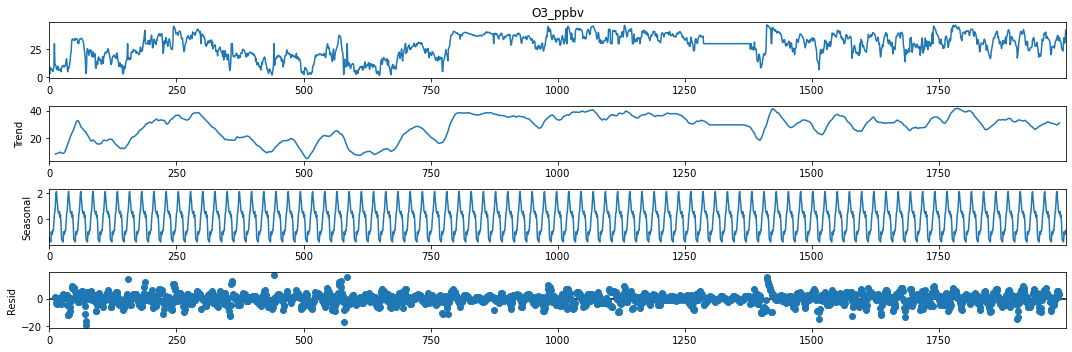

In [87]:
plt.rcParams.update({'figure.figsize': (15,5)})

ps =  df_GroundLevelOzone_merged_CAPMCABC1SAT['O3_ppbv'][:2000]
decompose_out = seasonal_decompose(x=ps, period = 24)
decompose_out.plot()

plt.show()

#### Feature Engineering

Automated feature engineering using Featuretools.

In [88]:
#Extract month (You can also extract weekday, year and other attributes however they are not relevant for this dataset)

#Create an entity set
entitySet = ft.EntitySet('TSEntitySet')

df_GroundLevelOzone_merged_CAPMCABC1SAT['index'] = df_GroundLevelOzone_merged_CAPMCABC1SAT.index

#Add dataframe
entitySet = entitySet.add_dataframe(
    dataframe_name='df_GroundLevelOzone_merged_CAPMCABC1SAT',
    dataframe=df_GroundLevelOzone_merged_CAPMCABC1SAT,
    index="index",
    # time_index="DateTimeStartLocalTime"
)

#Run deep feature synthesis (dfs)
df_features, feature_list  = ft.dfs(
    max_depth = 1,
    entityset=entitySet,
    target_dataframe_name="df_GroundLevelOzone_merged_CAPMCABC1SAT",    
    trans_primitives=['month'],
    features_only=False,
    primitive_options={
        'month': {
            'include_columns': {'df_GroundLevelOzone_merged_CAPMCABC1SAT': ['DateTimeStartLocalTime']}
        }
    }
)

print(f'df_GroundLevelOzone_merged_CAPMCABC1SAT.shape: {df_GroundLevelOzone_merged_CAPMCABC1SAT.shape}')
print(f'df_features.shape: {df_features.shape}')

# MONTH(DateTimeStartLocalTime) feature was added to the result
df_features.head(2)

df_GroundLevelOzone_merged_CAPMCABC1SAT.shape: (17520, 34)
df_features.shape: (17520, 22)


SiteID TimeZone  O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL  \
index                                                              
0      CAPMCABC1SAT      PST      4.1           V0           1.0   
1      CAPMCABC1SAT      PST      2.9           V0           1.0   

       HrStartLocalTime  HrEndLocalTime  HrStartUTC  HrEndUTC SiteID_original  \
index                                                                           
0                     0               1           8         9             SAT   
1                     1               2           9        10             SAT   

      SiteName                 CountryCode ProvinceStateCode  Latitude_deg  \
index                                                                        
0      Saturna  CA (CANADA) // CA (CANADA)                BC      48.77503   
1      Saturna  CA (CANADA) // CA (CANADA)                BC      48.77503   

       Longitude_deg  GroundElevAMSL_m                      LatLonRefDatum  \
index                                                                        
0         -123.12753               184  WGS84 (World Geodetic System 1984)   
1         -123.12753               184  WGS84 (World Geodetic System 1984)   

      Timezone       SiteLandUse  \
index                              
0          PST  Rural // Rurales   
1          PST  Rural // Rurales   

                                        SamplingHeightAG  O3_ppbv_imputed  \
index                                                                       
0      1991-2000: 2.0m; 2001-2013: 3m; 2014-onwards: ...              4.1   
1      1991-2000: 2.0m; 2001-2013: 3m; 2014-onwards: ...              2.9   

      MONTH(DateTimeStartLocalTime)  
index                                
0                                 1  
1                                 1

In [89]:
df_features.sort_values(by=['index'], inplace = True)

#Add the MONTH(DateTimeStartLocalTime) to 'df_GroundLevelOzone_merged_CAPMCABC1SAT' dataframe
df_GroundLevelOzone_merged_CAPMCABC1SAT['MonthNo'] = df_features['MONTH(DateTimeStartLocalTime)'].to_numpy()
df_GroundLevelOzone_merged_CAPMCABC1SAT.head(2)

SiteID DateStartLocalTime  TimeStartLocalTime DateEndLocalTime  \
0  CAPMCABC1SAT         2014-01-01 2022-03-04 00:00:00       2014-01-01   
1  CAPMCABC1SAT         2014-01-01 2022-03-04 01:00:00       2014-01-01   

     TimeEndLocalTime TimeZone DateStartUTC        TimeStartUTC DateEndUTC  \
0 2022-03-04 01:00:00      PST   2014-01-01 2022-03-04 08:00:00 2014-01-01   
1 2022-03-04 02:00:00      PST   2014-01-01 2022-03-04 09:00:00 2014-01-01   

           TimeEndUTC  O3_ppbv O3_ppbv_Flag  O3_ppbv_DetL  \
0 2022-03-04 09:00:00      4.1           V0           1.0   
1 2022-03-04 10:00:00      2.9           V0           1.0   

  DateTimeStartLocalTime DateTimeEndLocalTime  HrStartLocalTime  \
0    2014-01-01 00:00:00  2014-01-01 01:00:00                 0   
1    2014-01-01 01:00:00  2014-01-01 02:00:00                 1   

   HrEndLocalTime  HrStartUTC  HrEndUTC SiteID_original SiteName  \
0               1           8         9             SAT  Saturna   
1               2           9        10             SAT  Saturna   

                  CountryCode ProvinceStateCode  Latitude_deg  Longitude_deg  \
0  CA (CANADA) // CA (CANADA)                BC      48.77503     -123.12753   
1  CA (CANADA) // CA (CANADA)                BC      48.77503     -123.12753   

   GroundElevAMSL_m                      LatLonRefDatum Timezone  \
0               184  WGS84 (World Geodetic System 1984)      PST   
1               184  WGS84 (World Geodetic System 1984)      PST   

  StartDateOfSite EndDateOfSite       SiteLandUse  \
0      1991-05-28    2262-04-11  Rural // Rurales   
1      1991-05-28    2262-04-11  Rural // Rurales   

                                    SamplingHeightAG  O3_ppbv_imputed  index  \
0  1991-2000: 2.0m; 2001-2013: 3m; 2014-onwards: ...              4.1      0   
1  1991-2000: 2.0m; 2001-2013: 3m; 2014-onwards: ...              2.9      1   

   MonthNo  
0        1  
1        1

#### Time Series - Autoregressive Models

PACF

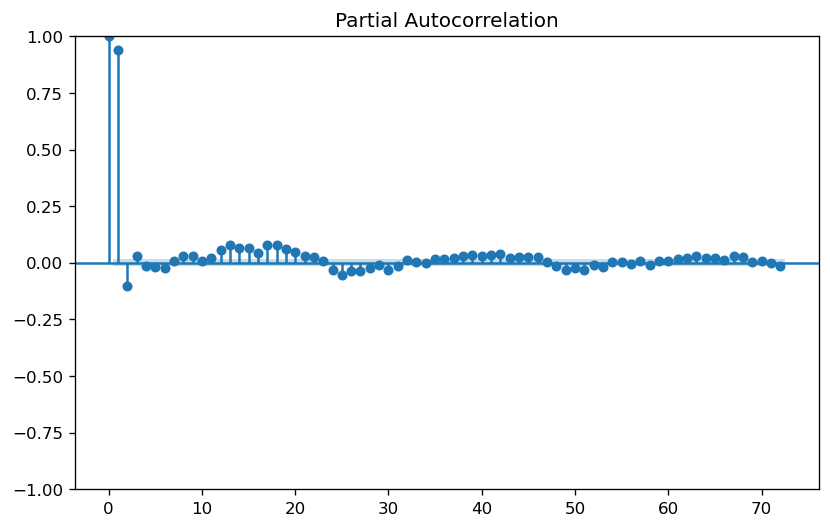

In [90]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})
plot_pacf(df_GroundLevelOzone_merged_CAPMCABC1SAT["O3_ppbv"].dropna(),method='yw', lags= 72)
plt.show()
#p=1

ACF

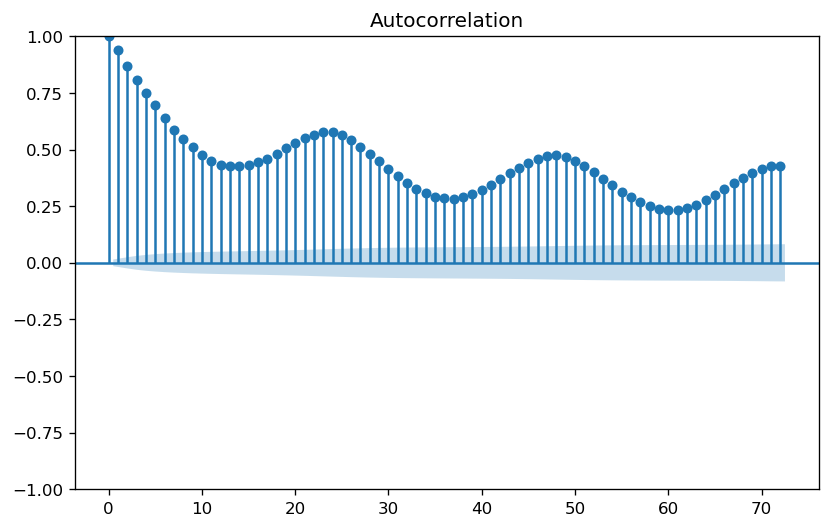

In [91]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})
plot_acf(df_GroundLevelOzone_merged_CAPMCABC1SAT["O3_ppbv"].dropna(), lags = 72)
plt.show()
#q=~10

In [92]:
maxiter=500

Create a TS dataframe

In [93]:
pred_date_range = pd.date_range(start = df_GroundLevelOzone_merged_CAPMCABC1SAT['DateTimeStartLocalTime'].dt.date.min(), 
                                freq = "H", 
                                end = df_GroundLevelOzone_merged_CAPMCABC1SAT['DateTimeStartLocalTime'].dt.date.max()
                                # periods = pred_periods+24
                               ) 

df_pred_ts = pd.DataFrame(data=pred_date_range, columns=["GeneratedDatetime"])
df_pred_ts["Date"] = pd.to_datetime(df_pred_ts["GeneratedDatetime"].dt.date)
df_pred_ts["Hour"] = df_pred_ts["GeneratedDatetime"].dt.hour
df_pred_ts["Month"] = df_pred_ts["GeneratedDatetime"].dt.month
df_pred_ts.drop(columns = ["GeneratedDatetime"], axis=1, inplace=True)

# df_pred_ts.head(2)
df_pred_ts.tail(2)

Date  Hour  Month
17495 2015-12-30    23     12
17496 2015-12-31     0     12

In [94]:
df_pred_ts = pd.merge(df_pred_ts,df_GroundLevelOzone_merged_CAPMCABC1SAT, left_on = ["Date","Hour"], right_on = ["DateStartLocalTime","HrStartLocalTime"], how="left")
df_pred_ts = df_pred_ts[['Date','Hour','Month','O3_ppbv']]
df_pred_ts.columns = ['Date','Hour','MonthNo','O3_ppbv']
df_pred_ts.head(2)

Date  Hour  MonthNo  O3_ppbv
0 2014-01-01     0        1      4.1
1 2014-01-01     1        1      2.9

In [95]:
df_pred_ts[df_pred_ts['O3_ppbv'].isnull()]

Empty DataFrame
Columns: [Date, Hour, MonthNo, O3_ppbv]
Index: []

In [96]:
df_pred_ts.tail()

Date  Hour  MonthNo  O3_ppbv
17492 2015-12-30    20       12     22.0
17493 2015-12-30    21       12     23.9
17494 2015-12-30    22       12     24.0
17495 2015-12-30    23       12     25.4
17496 2015-12-31     0       12     21.3

Fit model and cross validate

In [97]:
tscv = TimeSeriesSplit(n_splits=2, test_size=24)

In [98]:
# train_on_last_N_days = 180
# df_GroundLevelOzone_merged_CAPMCABC1SAT_subset = df_GroundLevelOzone_merged_CAPMCABC1SAT[-1*24*train_on_last_N_days:]
# df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.sort_values(by = ['DateTimeStartLocalTime'], inplace = True)
# df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.reset_index(inplace = True )

# df_GroundLevelOzone_merged_CAPMCABC1SAT_subset = df_GroundLevelOzone_merged_CAPMCABC1SAT.copy(deep = True)
# df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.sort_values(by = ['DateTimeStartLocalTime'], inplace = True)

df_GroundLevelOzone_merged_CAPMCABC1SAT_subset = df_pred_ts.copy(deep = True)
df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.sort_values(by = ['Date', 'Hour'], inplace = True)

print(f'df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.shape: {df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.shape}')

df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.shape: (17497, 4)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60393D+00    |proj g|=  4.59651D-01


 This problem is unconstrained.



At iterate    5    f=  2.57264D+00    |proj g|=  7.47543D-02

At iterate   10    f=  2.57183D+00    |proj g|=  3.01292D-02

At iterate   15    f=  2.56802D+00    |proj g|=  7.11200D-02

At iterate   20    f=  2.55795D+00    |proj g|=  2.60143D-01

At iterate   25    f=  2.55169D+00    |proj g|=  1.80139D-01

At iterate   30    f=  2.54617D+00    |proj g|=  8.77227D-02

At iterate   35    f=  2.54611D+00    |proj g|=  4.61523D-03

At iterate   40    f=  2.54608D+00    |proj g|=  2.17818D-03

At iterate   45    f=  2.54608D+00    |proj g|=  4.51312D-03

At iterate   50    f=  2.54608D+00    |proj g|=  1.39842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

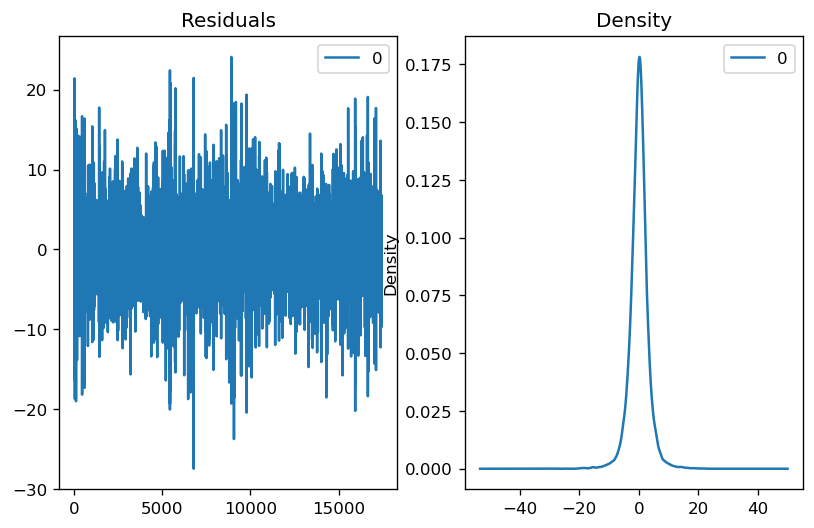

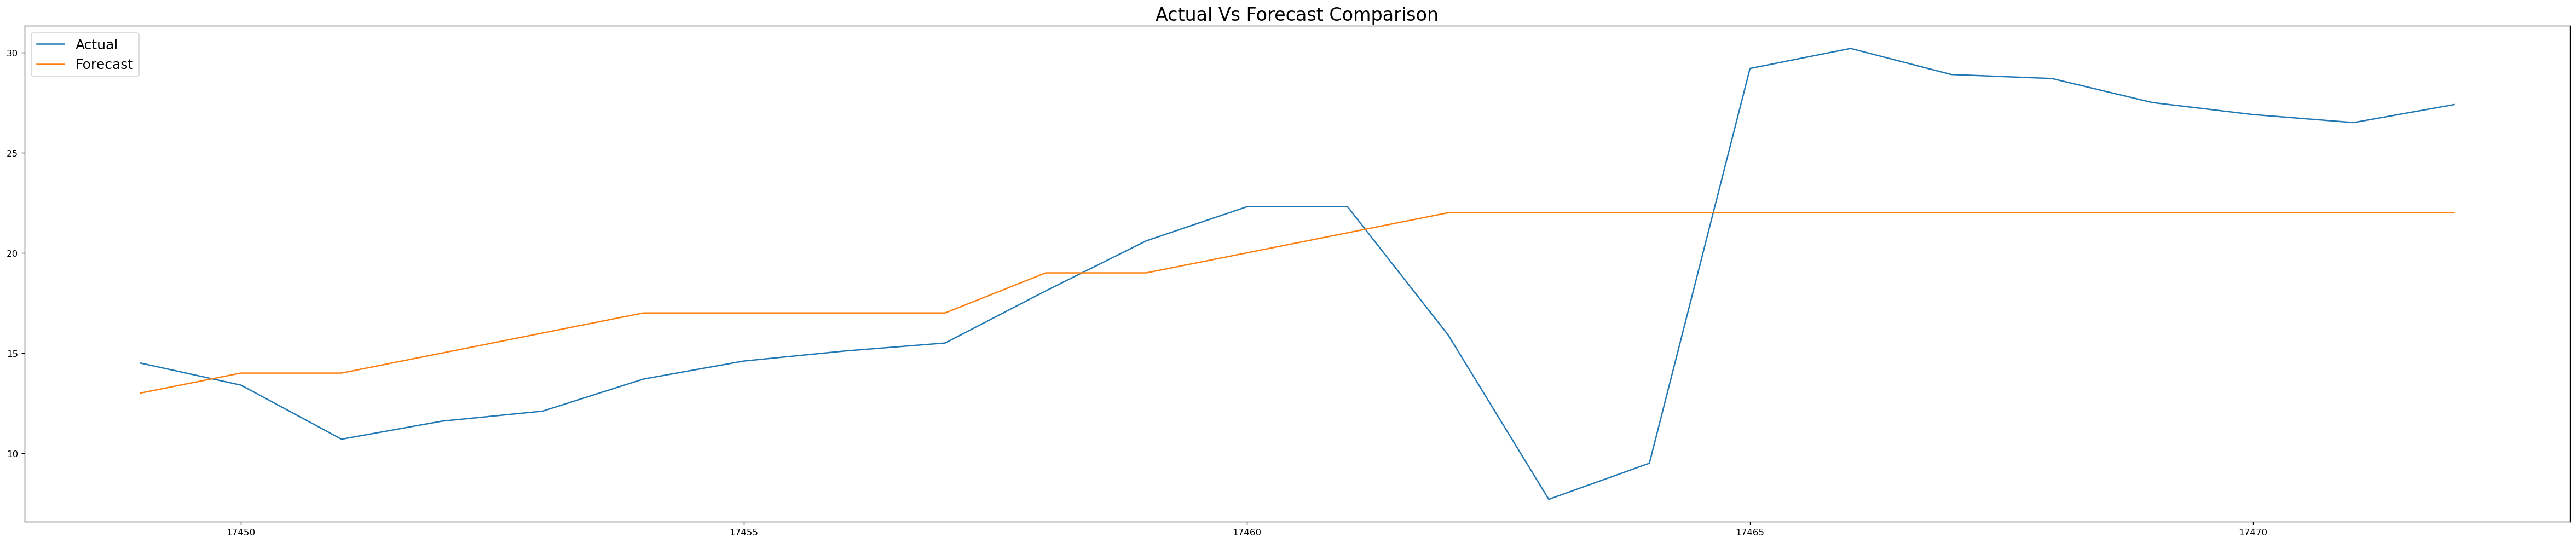

MAE: 4.5874999999999995
MAPE: 0.30352805948572964


In [99]:
for train_index, test_index in tscv.split(df_GroundLevelOzone_merged_CAPMCABC1SAT_subset):
    
    df_train = df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.iloc[train_index]
    df_test = df_GroundLevelOzone_merged_CAPMCABC1SAT_subset.iloc[test_index]   
     
    
    model_x = SARIMAX(df_train['O3_ppbv'], 
                      order = (1,0,2), 
                      seasonal_order = (1,0,4,24), 
                      enforce_stationarity = False,
                      exogenous = df_train['MonthNo']
                     )
    model_fit_x = model_x.fit(maxiter = maxiter)

    print(model_fit_x.summary())
    
    # Plot residual errors
    residuals = pd.DataFrame(model_fit_x.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
    # Actual vs Fitted
    pred = model_fit_x.predict(start = df_test.index.min(), end = df_test.index.max(), exog = df_test['MonthNo'])
    pred = pred.round()

    plt.figure(figsize=(50,10))
    plt.plot(df_test['O3_ppbv'])
    plt.plot(pred)
    plt.legend(labels = ['Actual', 'Forecast'], loc = 'upper left', fontsize=15)
    plt.title('Actual Vs Forecast Comparison', fontsize = 20)
    plt.show()
    
    print('===================================================================')
    #MAE
    mae = np.mean(np.abs
                  (
                      pred 
                      - 
                      df_test['O3_ppbv']                 
                  )
                 )
    print(f"MAE: {mae}")
    
    #MAPE
    mape = np.mean(np.abs
                  (
                      pred 
                      - 
                      df_test['O3_ppbv'].replace(0,1)                 
                  )
                   /
                  np.abs
                  (
                      df_test['O3_ppbv'].replace(0,1)
                  )
                 )
    print(f"MAPE: {mape}")
    print('===================================================================')
    
    break #To run 1 iteration only

Observation: From above our model has picked-up the upward trend, but requires a bit more tuning to model seasonality in the data.